## AIM: Train a multiclass classification model for predicting the psychiatric diagnosis based on EEG features

We will start with training a Support Vector Classification model to predict psychiatric diagnosis with the variance in power per frequency band per channel group (frontal, central, parietal, occipital).

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

### Loading in participants data
and excluding replication data

In [49]:
df_participants = pd.read_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\df_participants.pkl')
print(f'all participants: {df_participants.shape}')
df_participants = df_participants[df_participants['DISC/REP'] == 'DISCOVERY'] # select the discovery group
print(f'discovery participants: {df_participants.shape}')
df_participants[0:15]

all participants: (1347, 11)
discovery participants: (1227, 11)


,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO
120,sub-87963457,DISCOVERY,BURNOUT,BURNOUT,NaN,NaN,0,1,1,True,True
121,sub-87963593,DISCOVERY,BURNOUT,BURNOUT,NaN,52.90,1,1,1,True,True
122,sub-87963725,DISCOVERY,SMC,UNKNOWN,NaN,77.99,0,1,1,True,True
123,sub-87963769,DISCOVERY,SMC,UNKNOWN,NaN,83.30,1,1,1,True,True
124,sub-87964717,DISCOVERY,SMC,UNKNOWN,NaN,58.29,0,1,2,True,True
125,sub-87964717,DISCOVERY,SMC,UNKNOWN,NaN,61.06,0,3,2,True,True
126,sub-87965301,DISCOVERY,SMC,UNKNOWN,NaN,58.39,0,1,1,True,True
127,sub-87965393,DISCOVERY,BURNOUT,BURNOUT,NaN,50.78,1,1,1,True,True
128,sub-87965801,DISCOVERY,BURNOUT,BURNOUT,NaN,47.39,1,1,1,True,True
129,sub-87965889,DISCOVERY,BURNOUT,BURNOUT,NaN,51.15,1,1,1,True,True


### Creating montage and info object for PSD calculation with MNE

In [2]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }

# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}


## Create montage
montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')

# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


### Feature extraction and storing in df

In [54]:
# calculate variance in power per freq band and per channel group for each file and store in dataframe
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\preprocessed"

#exlude_dirs = ['preprocessed', 'results_manuscript', 'adhd_sample'] # exclude these directories
sample_ids = df_participants['participants_ID'].tolist() # list of participants to include
#sample_ids = ['sub-87966293']

df_features = pd.DataFrame() # create empty dataframe to store features

# counter for progress
count = 1
if count == 1:
    total_files = 0
    for _, dirs, files in os.walk(eeg_dir):
        #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
        total_files += len([file for file in files if '.npy' in file])
    total_files -= len(sample_ids) * 2

for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    #dirs[:] = [d for d in dirs if d not in exlude_dirs] # exclude directories
    for file in files:
        if any(sample_id in file for sample_id in sample_ids): # filter participants to include
            if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                filepath = os.path.join(subdir, file) # path to eeg file

                # needs specific info object, because has one less channel
                info = mne.create_info(ch_names=ch_names[:32], ch_types=ch_types[:32], sfreq=500)
                info.set_montage(montage=montage, on_missing= 'raise')

                preprocessed_eeg = np.load(filepath, allow_pickle = True)
                raw = mne.io.RawArray(np.squeeze(preprocessed_eeg['data']), info)

                # epoch the data
                epochs = mne.make_fixed_length_epochs(raw, duration = 9.95, overlap = 0)

                if 'EC' in file:
                    cond = 'EC'
                if 'EO' in file:
                    cond = 'EO'

                # determine age, gender, and diagnosis of participant
                age = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'age'].values[0]
                gender = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'gender'].values[0]
                if df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'formal_status'].values[0] == 'UNKNOWN':
                    diagnosis = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'indication'].values[0]
                if df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'formal_status'].values[0] != 'UNKNOWN':
                    diagnosis = df_participants.loc[df_participants['participants_ID'] == file.split('_')[0], 'formal_status'].values[0]

                # add data to empty dictionary
                feature_dict = {}
                feature_dict['ID'] = [file.split('_')[0]] * epochs.get_data().shape[0]
                feature_dict['age'] = [age] * epochs.get_data().shape[0]
                feature_dict['gender'] = [gender] * epochs.get_data().shape[0]
                feature_dict['diagnosis'] = [diagnosis] * epochs.get_data().shape[0]
                feature_dict['EO/EC'] = [cond] * epochs.get_data().shape[0]
                feature_dict['epoch'] = list(range(1, epochs.get_data().shape[0] + 1))
                
                # calculate TFR per band and channel group using multitaper convolution
                for band in bands:
                    for group in channel_groups:
                        tfr_mt = tfr_multitaper(
                            epochs,
                            freqs=bands[band],
                            n_cycles=(bands[band] / 2),
                            time_bandwidth=4, # just random for now
                            use_fft=True,
                            return_itc=False,
                            average=False,
                            decim=8, # decim reduces sampling rate of the tf decomposition by the defined factor
                            n_jobs=-1,
                            picks=channel_groups[group])
                        tfr_mt.apply_baseline((None, None), mode='logratio') # baseline correction, (None, None) = whole epoch

                        # compute average spectral spower per epoch per channel group
                        tfr_mt_std = np.std(tfr_mt.data, axis = 3) # calculate stdev over time
                        tfr_mt_std_mean = np.mean(tfr_mt_std, axis = (1, 2)) # calculate mean of stdev over channels and frequencies

                        feature_dict[f'{group}_{band}'] = tfr_mt_std_mean # add to dictionary
                
                # add to dataframe
                df_features = pd.concat([df_features, pd.DataFrame(feature_dict)], ignore_index = True)

                print(f'\rProgress: {count}/{total_files} files processed.', end = '')
                count += 1
                
print(f'\n{df_features.shape}')
df_features.sample(5)

Progress: 2288/2692 files processed.
(27461, 26)


,ID,age,gender,diagnosis,EO/EC,epoch,frontal_delta,central_delta,parietal_delta,occipital_delta,...,parietal_alpha,occipital_alpha,frontal_beta,central_beta,parietal_beta,occipital_beta,frontal_gamma,central_gamma,parietal_gamma,occipital_gamma
23315,sub-88065425,44.62,0,MDD,EO,7,0.358983,0.346171,0.351030,0.383055,...,0.375147,0.392969,0.303941,0.287612,0.321925,0.344954,0.304924,0.279593,0.273020,0.271866
12111,sub-88025057,67.55,1,MDD,EO,10,0.388807,0.391471,0.363964,0.344105,...,0.354912,0.325065,0.300517,0.299131,0.289363,0.271069,0.270618,0.264079,0.264577,0.264958
7604,sub-88013629,10.97,1,NaN,EO,9,0.476117,0.394402,0.427574,0.379410,...,0.366636,0.316806,0.341467,0.342962,0.359685,0.383740,0.385861,0.383113,0.386890,0.454251
15171,sub-88038025,11.38,1,ADHD,EC,10,0.399910,0.415822,0.412045,0.366262,...,0.365943,0.349264,0.310514,0.301646,0.286953,0.304944,0.277846,0.269927,0.263425,0.270947
3797,sub-88005485,16.78,0,ADHD,EC,6,0.441210,0.399826,0.412588,0.446614,...,0.311833,0.297232,0.270807,0.284007,0.281161,0.305681,0.289532,0.286402,0.284343,0.285580


In [55]:
df_features.to_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features/df_std_features.pkl')

In [36]:
df_features = pd.read_pickle('D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features/df_std_features.pkl')
df_features['EO/EC'] = (df_features['EO/EC'] == 'EO').astype('int')
df_features.sample(7)

,ID,age,gender,diagnosis,EO/EC,epoch,frontal_delta,central_delta,parietal_delta,occipital_delta,...,parietal_alpha,occipital_alpha,frontal_beta,central_beta,parietal_beta,occipital_beta,frontal_gamma,central_gamma,parietal_gamma,occipital_gamma
16374,sub-88041985,8.50,0,ADHD,0,1,0.387323,0.378364,0.360070,0.512727,...,0.272030,0.333501,0.291277,0.317483,0.293116,0.293047,0.387753,0.411731,0.384163,0.372664
13871,sub-88030597,35.83,1,ASPERGER,0,6,0.416830,0.396820,0.391571,0.385925,...,0.292649,0.255081,0.282296,0.286908,0.283941,0.278681,0.279572,0.284517,0.278629,0.285565
7574,sub-88013585,8.40,1,NaN,1,3,0.470898,0.443608,0.414777,0.455054,...,0.363175,0.472853,0.295200,0.269942,0.279340,0.292952,0.327571,0.303683,0.293768,0.277052
18264,sub-88047201,60.89,1,NaN,0,7,0.398207,0.414958,0.384917,0.411218,...,0.292317,0.271458,0.283078,0.283747,0.285445,0.298436,0.282379,0.282038,0.279834,0.303944
11389,sub-88023257,55.44,1,TINNITUS,1,8,0.359093,0.346058,0.338549,0.390373,...,0.688885,0.790291,0.327711,0.329335,0.386055,0.433965,0.282311,0.269367,0.275891,0.290443
15472,sub-88039193,6.90,1,ADHD,1,11,0.438746,0.407550,0.402102,0.383239,...,0.298643,0.347231,0.295684,0.301380,0.287210,0.285396,0.352699,0.346316,0.341725,0.331461
25154,sub-88071677,70.61,1,MDD,0,10,0.363135,0.355511,0.354426,0.369215,...,0.354929,0.349338,0.286485,0.290387,0.276918,0.274942,0.257642,0.265020,0.264955,0.265478


In [37]:
# select top 5 diagnoses for now
top_5 = df_features['diagnosis'].value_counts()[:5].index.tolist()
df_features = df_features[df_features['diagnosis'].isin(top_5)]
df_features['diagnosis'] = df_features['diagnosis'].astype('category')
df_features['diagnosis'].value_counts()


diagnosis
MDD        7428
ADHD       4079
SMC        2052
HEALTHY    1128
OCD        1080
Name: count, dtype: int64

In [39]:
# label encode diagnosis (alphabatic order by default)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_features['diagnosis'] = le.fit_transform(df_features['diagnosis'])
print(df_features['diagnosis'].value_counts())
df_features['diagnosis'] = df_features['diagnosis'].astype('category')
print(df_features['diagnosis'].dtype)

diagnosis
2    7428
0    4079
4    2052
1    1128
3    1080
Name: count, dtype: int64
category


### Training the model (SVC)

In [42]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC


# assign groups (IDs) for GroupKFold
groups = df_features['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for band in bands:
    for group in channel_groups:
        numeric_cols.append(f'{group}_{band}')
cat_cols = ['gender', 'EO/EC']
 
X = df_features.drop(columns = ['ID', 'diagnosis', 'epoch']) #########
Y = df_features['diagnosis']

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')) # median imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__gamma': [0.1, 1, 10, 100],
'rbf_svm__kernel': ['rbf'],
}

# final pipeline
steps = [('col_trans', col_trans), ('rbf_svm', SVC(class_weight = 'balanced'))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=4,
                        verbose=2)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=2,
                                 n_jobs=4)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


15767
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'rbf_svm__C': 100, 'rbf_svm__gamma': 0.1, 'rbf_svm__kernel': 'rbf'}
Best f1-score: 0.36850877162811385


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 27.7min finished


SVM test scores: [0.3698951  0.38058205 0.34088699 0.36680002 0.35398466]
Mean SVM test score: 0.3624297633730495
Mean classification report:


ValueError: Number of classes, 0, does not match size of target_names, 5. Try specifying the labels parameter

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:  1.1min remaining:   43.0s


f1_score: 0.36277330735664454

classification report:
               precision    recall  f1-score   support

        ADHD       0.37      0.43      0.40      4079
     HEALTHY       0.10      0.11      0.10      1128
         MDD       0.49      0.47      0.48      7428
         OCD       0.08      0.06      0.07      1080
         SMC       0.18      0.15      0.16      2052

    accuracy                           0.37     15767
   macro avg       0.24      0.24      0.24     15767
weighted avg       0.36      0.37      0.36     15767



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.9min finished


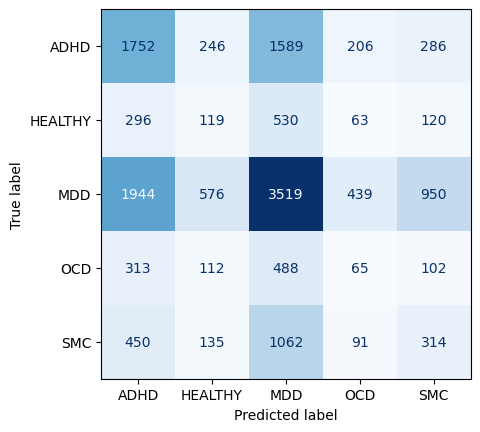

In [60]:
# final pipeline
steps = [('col_trans', col_trans), ('rbf_svm', svm.SVC(kernel = 'rbf', C = 100, gamma = 0.1, class_weight = 'balanced'))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, verbose=2, n_jobs=4)    
class_labels = sorted(top_5)
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted'))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
